This notebook defines a forecasting task for SPI-3 and quantifies the impact of non-stationarity using simple baseline models under an explicit temporal split.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))


## Imports & configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.data.dataloader import load_precipitation
from src.indices.spi import compute_spi
from src.splits.temporal import split_pre_post


In [3]:
GAUGE_ID = "03004"

precip = load_precipitation(GAUGE_ID)
spi3 = compute_spi(precip, scale=3)


Forecasting task definition

The task is to predict SPI-3 one month ahead using past SPI-3 values.
Formally, given SPI-3 at time t, the goal is to forecast SPI-3 at t+1.

This setup isolates temporal predictability and allows controlled evaluation under distribution shift.

In [4]:
train, test = split_pre_post(spi3, split_year=2000)

print(f"Train period: {train.index.min().year}–{train.index.max().year}")
print(f"Test period:  {test.index.min().year}–{test.index.max().year}")


Train period: 1980–2000
Test period:  2001–2020


<Figure size 1000x400 with 0 Axes>

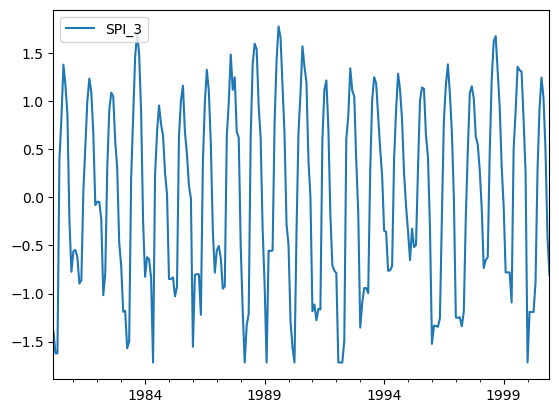

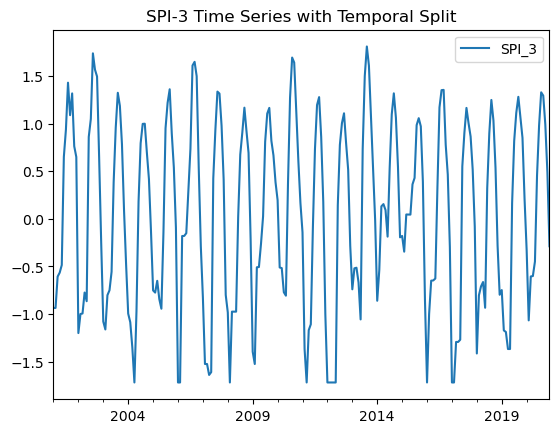

In [5]:
plt.figure(figsize=(10,4))
train.plot(label="Train (≤ 2000)")
test.plot(label="Test (> 2000)")
plt.axvline(pd.Timestamp("2000-12-31"), color="k", linestyle="--")
plt.title("SPI-3 Time Series with Temporal Split")
plt.legend()
plt.show()


the model never sees the future climate

In [6]:
def persistence_forecast(series):
    """
    One-step-ahead persistence forecast:
    SPI(t+1) = SPI(t)
    """
    return series.shift(1)


In [7]:
train_pred = persistence_forecast(train)
test_pred  = persistence_forecast(test)

# Align (drop first NaN)
train_true = train.iloc[1:]  #is required to align each SPI(t+1) value with its persistence prediction SPI(t).
train_pred = train_pred.iloc[1:]

test_true = test.iloc[1:]
test_pred = test_pred.iloc[1:]


In [8]:
from sklearn.metrics import root_mean_squared_error

rmse_train = root_mean_squared_error(train_true, train_pred)
rmse_test = root_mean_squared_error(test_true, test_pred)

mae_train = mean_absolute_error(train_true, train_pred)
mae_test = mean_absolute_error(test_true, test_pred)

print("Persistence baseline performance:")
print(f"Train RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}")
print(f"Test RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}")

Persistence baseline performance:
Train RMSE: 0.638, MAE: 0.462
Test RMSE: 0.617, MAE: 0.453


In [9]:
rmse_ratio = rmse_test / rmse_train

print(f"RMSE inflation (test / train): {rmse_ratio:.2f}")


RMSE inflation (test / train): 0.97


In [11]:
y_true = test_true["SPI_3"]
y_pred = test_pred["SPI_3"]

mask = (
    (y_true < -1.5) &
    y_true.notna() &
    y_pred.notna()
)

print("Extreme cases:", (y_true < -1.5).sum())
print("Valid extreme cases:", mask.sum())

rmse_extreme = root_mean_squared_error(
    y_true[mask],
    y_pred[mask]
)

print(f"RMSE during severe drought (SPI-3 < -1.5): {rmse_extreme:.3f}")


Extreme cases: 18
Valid extreme cases: 18
RMSE during severe drought (SPI-3 < -1.5): 0.635


Simple baselines remain competitive in mean error, but distributional shifts motivate careful evaluation and extreme-aware metrics.”

## Replicating the same persistence model for SPI-6 

Train period: 1980–2000
Test period:  2001–2020


<Figure size 1000x400 with 0 Axes>

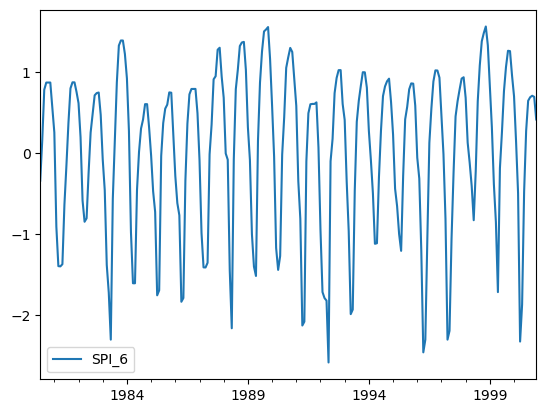

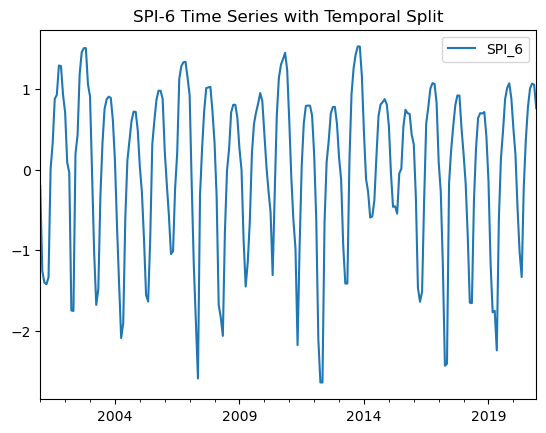

Persistence baseline performance:
Train RMSE: 0.634, MAE: 0.458
Test RMSE: 0.622, MAE: 0.451
RMSE inflation (test / train): 0.98
Extreme cases: 25
Valid extreme cases: 25
RMSE during severe drought (SPI-6 < -1.5): 0.750


In [13]:
## Imports & configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.data.dataloader import load_precipitation
from src.indices.spi import compute_spi
from src.splits.temporal import split_pre_post

GAUGE_ID = "03004"

precip = load_precipitation(GAUGE_ID)
spi6 = compute_spi(precip, scale=6)

train, test = split_pre_post(spi6, split_year=2000)

print(f"Train period: {train.index.min().year}–{train.index.max().year}")
print(f"Test period:  {test.index.min().year}–{test.index.max().year}")

plt.figure(figsize=(10,4))
train.plot(label="Train (≤ 2000)")
test.plot(label="Test (> 2000)")
plt.axvline(pd.Timestamp("2000-12-31"), color="k", linestyle="--")
plt.title("SPI-6 Time Series with Temporal Split")
plt.legend()
plt.show()


def persistence_forecast(series):
    """
    One-step-ahead persistence forecast:
    SPI(t+1) = SPI(t)
    """
    return series.shift(1)

train_pred = persistence_forecast(train)
test_pred  = persistence_forecast(test)

# Align (drop first NaN)
train_true = train.iloc[1:]  #is required to align each SPI(t+1) value with its persistence prediction SPI(t).
train_pred = train_pred.iloc[1:]

test_true = test.iloc[1:]
test_pred = test_pred.iloc[1:]

from sklearn.metrics import root_mean_squared_error

rmse_train = root_mean_squared_error(train_true, train_pred)
rmse_test = root_mean_squared_error(test_true, test_pred)

mae_train = mean_absolute_error(train_true, train_pred)
mae_test = mean_absolute_error(test_true, test_pred)

print("Persistence baseline performance:")
print(f"Train RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}")
print(f"Test RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}")
rmse_ratio = rmse_test / rmse_train

print(f"RMSE inflation (test / train): {rmse_ratio:.2f}")

y_true = test_true["SPI_6"]
y_pred = test_pred["SPI_6"]

mask = (
    (y_true < -1.5) &
    y_true.notna() &
    y_pred.notna()
)

print("Extreme cases:", (y_true < -1.5).sum())
print("Valid extreme cases:", mask.sum())

rmse_extreme = root_mean_squared_error(
    y_true[mask],
    y_pred[mask]
)

print(f"RMSE during severe drought (SPI-6 < -1.5): {rmse_extreme:.3f}")
